# Women in Data Science Datathon 2021

This notebook was produced by Leonie and downloaded from [kaggle](https://www.kaggle.com/iamleonie/wids-datathon-2021-diabetes-detection).  

Join us in this year's [WiDS Datathon competition](https://www.kaggle.com/c/widsdatathon2021/overview/description)! The datathon is "*open to individuals or teams of up to 4; at least half of each team must be women (individuals identifying as female participants)*".

# Problem Definition

In the Women in Data Science (WiDS) Datathon 2021, we will build a model to **determine whether a patient has been diagnosed with Diabetes Mellitus before** within the first 24 hours of being admitted to an Intensive Care Unit (ICU).
To improve a patient's outcome in an ICU knowledge about their medical conditions can improve clinical decisions.
However, often a patient's medical records are not immediately available due to transfer times. 
An additional challenge is when a patient is not able to provide such information due to their health condition, e.g. shock or unconsiousness.
Therefore, it is important to be able to diagnose whether a patient has chronical diseases based on data that can be gathered within the first 24 hours of being admitted to an ICU.  

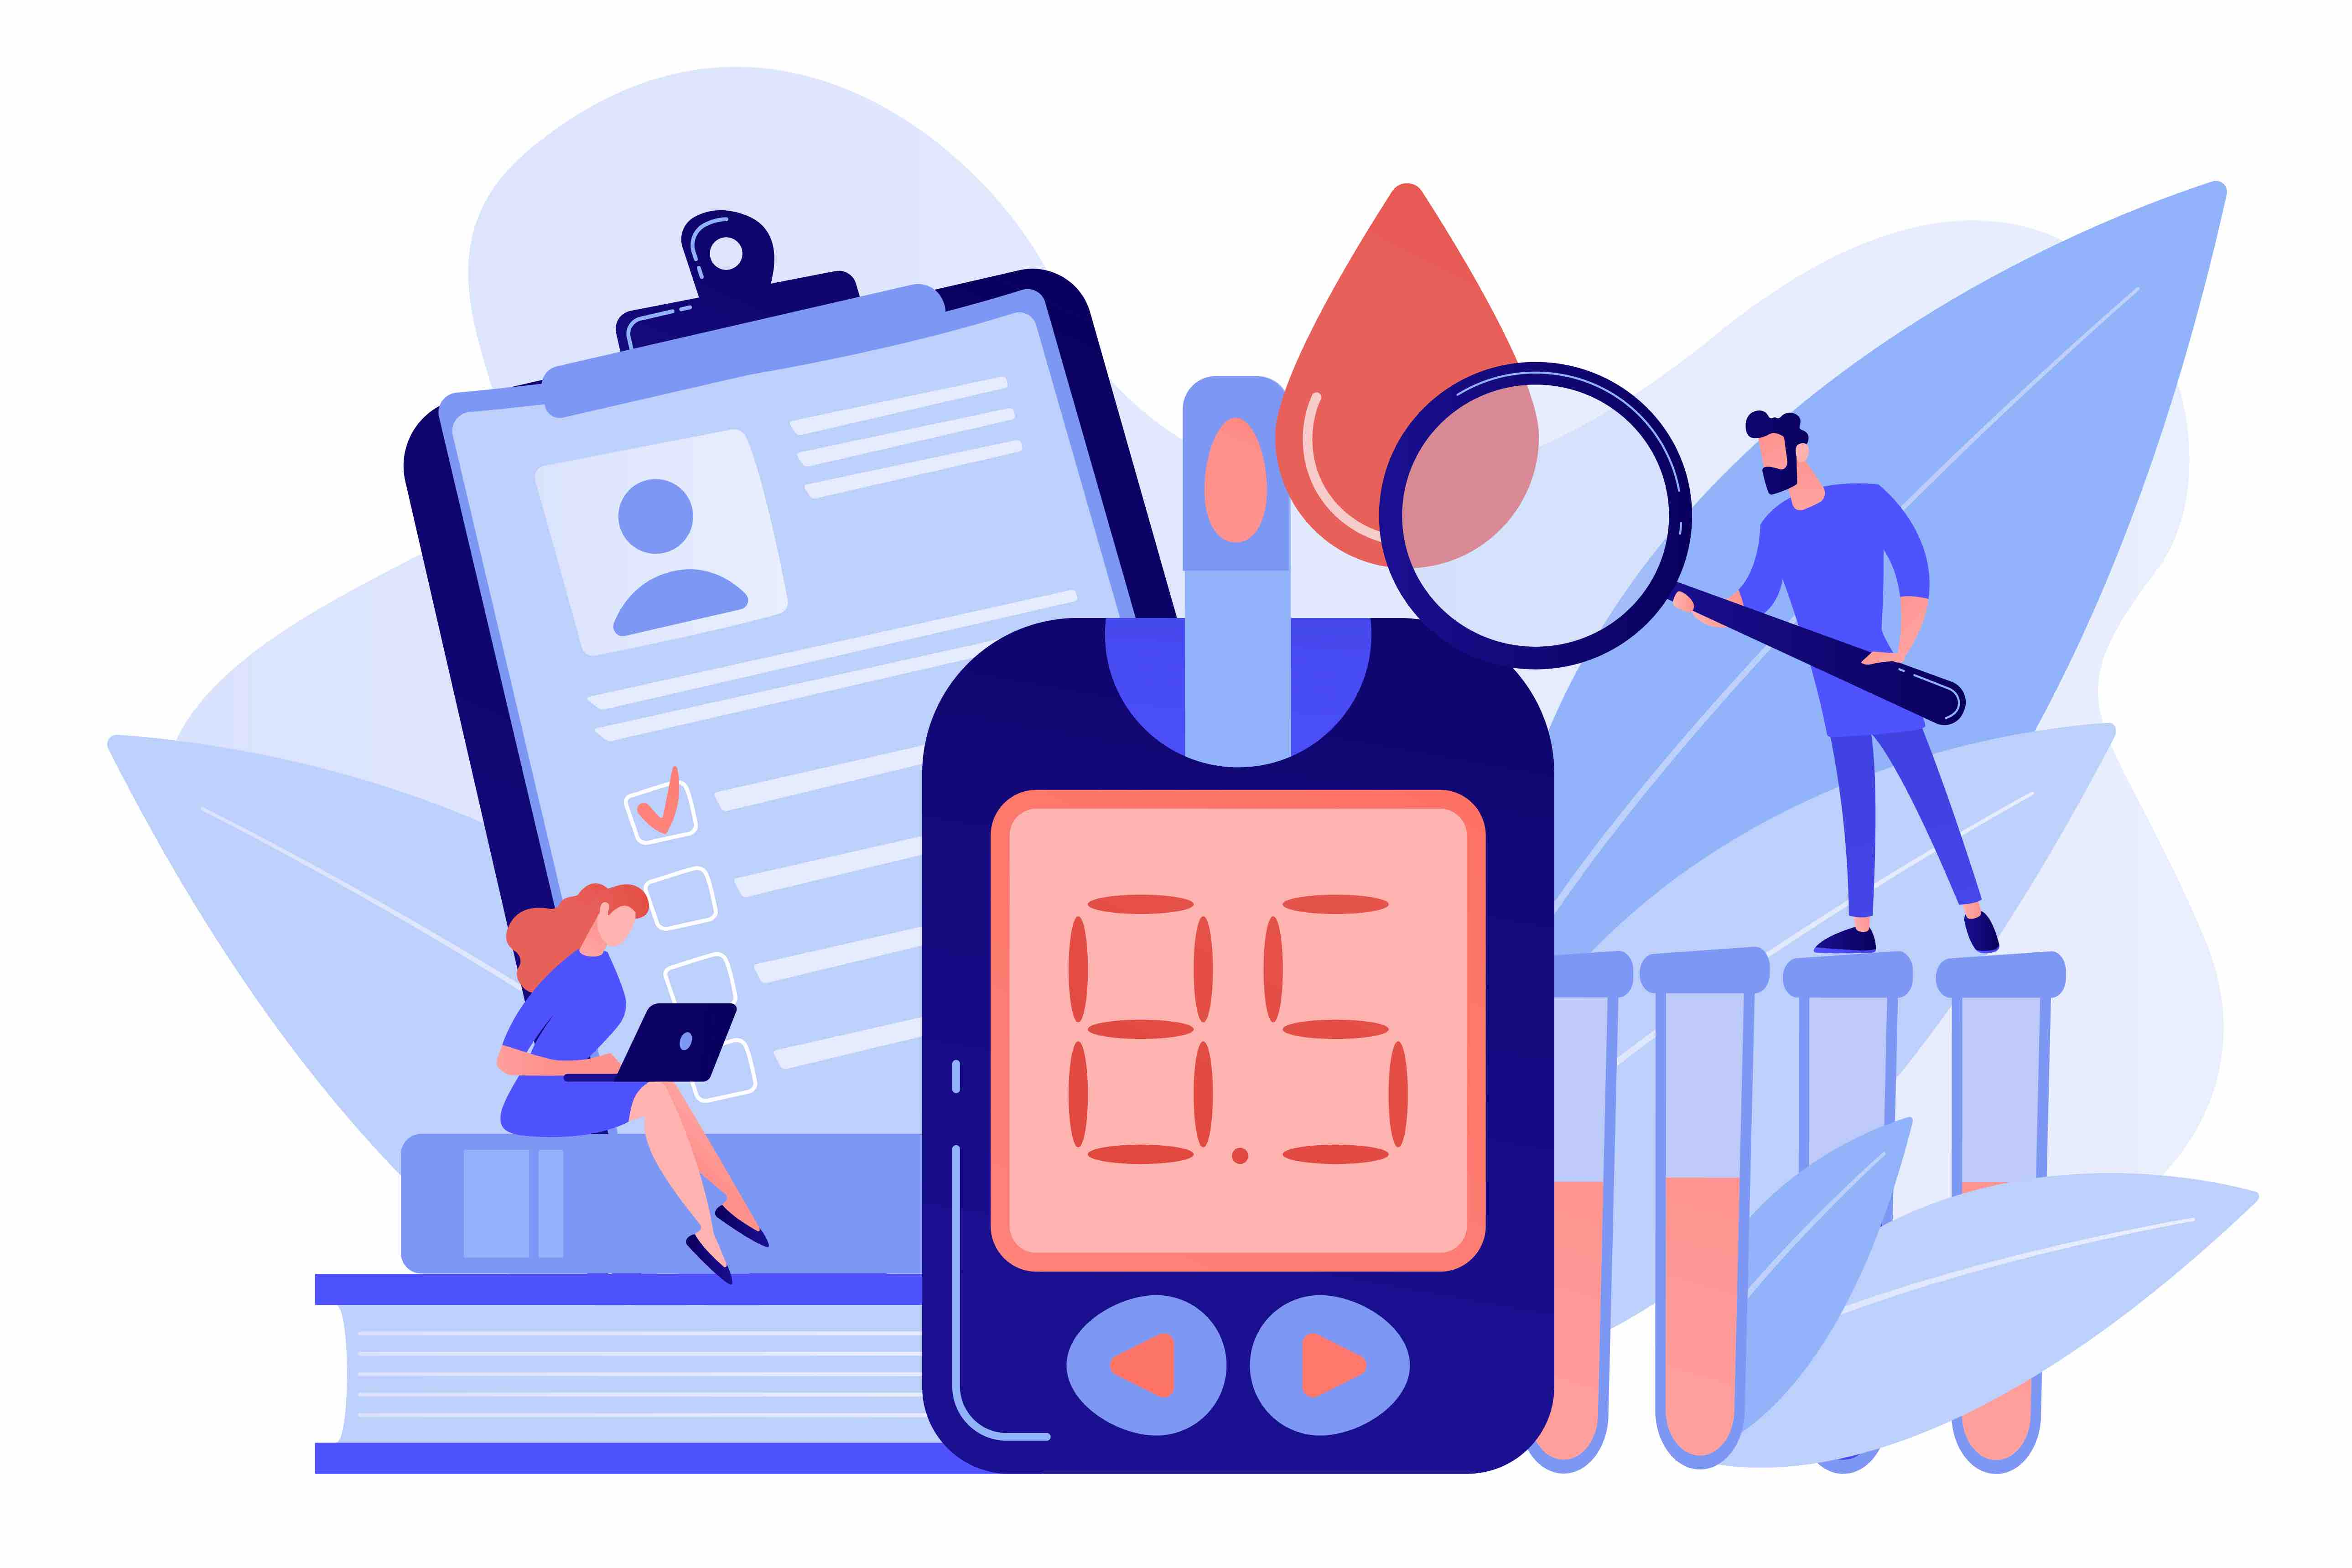   
<br> 
<a href="http://www.freepik.com" style="float: right;">Designed by vectorjuice / Freepik</a>  



# TL;DR
* [Diabetes Mellitus](#Diabetes-Mellitus)<br>
* [Data Overview](#Data-Overview)<br>
* [Data Cleaning](#Data-Cleaning)<br>
    * Drop identifiers (`encounter_id`, `hospital_id`, `icu_id`)
    * Drop measurements taken in the first hour (`h1...min/max`) because high ratio of missing values and redundant with `d1_...min/max` columns
    * Drop duplicates in blood pressure columns (`invasive`/`noninvasive`)
    * Drop readmission status (`readmission_status`) because only one unique value 
    * drop 30 rows in training data with implausible age (0)
* [Handling Missing Values](#Handling-Missing-Values)<br>
    * Merge `...apache`  to `d1_...max` and then drop `...apache` column for `albumin`, `bilirubin` , `bun`, `creatinine`, `glucose`,  `hematocrit`, `sodium`, `wbc`, and `heart_rate`
    * Weight and height filled with mean for gender
    * Fill the missing values of the Oxygenation index `d1_pao2fio2ratio_max` with `pao2_apache`/`fio2_apache`.
    * Fill the missing values for `gender` with 'Unknown'
    * Fill the missing values for `ethnicity` with the already available value 'Other/Unknown'.
* [Feature Engineering](#Feature-Engineering)<br>
    * Reconstructed limited weight and limited height from BMI
    * BMI Categories (underweight, healthy weight, overweight, obese)
    * Range and Mean from `d1..._min/max`
    * Blood pressure categories from systolic and diastolic blood pressure
    * Sum of Glasgow Coma Scale (GCS)
* [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-EDA)<br>
    * Target correlates to BMI
    * Glucose related features are one of the most important features for diabetes detection
    * Target has minor correlation to blood pressure category (could indicate level of fitness)
    * Mean BUN and mean creatine can help detect diabetes
* [Experiments](#Experiments)<br>
    * Clustering of diabetes patients into type 1, type 2 and gestational diabetes patients with KMeans did not work
* [Dealing with Imbalanced Data](#Dealing-with-Imbalanced-Data)<br>
    
# Diabetes Mellitus

According to the World Health Organization (WHO) Diabetes Mellitus, or commonly know as diabetes, is defined as follows:
> Diabetes is a chronic disease that occurs either when the pancreas **does not produce enough insulin or when the body cannot effectively use the insulin it produces**. Insulin is a hormone that regulates blood sugar. Hyperglycaemia, or **raised blood sugar**, is a common effect of uncontrolled diabetes and over time leads to serious damage to many of the body's systems, especially the nerves and blood vessels. - [WHO Diabetes Fact Sheet](https://www.who.int/news-room/fact-sheets/detail/diabetes)

There are two types of diabetes - **Type 1 diabetes and Type 2 diabetes**. Type 2 diabetes is more common than Type 1 diabetes and often results from excess body weight and physical inactivity while Type 1 diabetes is independent on body size. Additionally, there is **Gestational diabetes** in which a woman without diabetes develops high blood sugar levels during pregnancy. The latter usually resolves after birth while the other two types of diabetes have to be treated in the longterm.

Around **8.5 % of the adult population** is diagnosed with Diabetes [2] independent of the gender. 

Diabetes mellitus is characterized by high blood sugar levels over a prolonged period of time and is diagnosed by demonstrating any one of the following:
* Fasting plasma glucose level ≥ 7.0 mmol/L (126 mg/dL)
* Plasma glucose ≥ 11.1 mmol/L (200 mg/dL) two hours after a 75 gram oral glucose load as in a glucose tolerance test
* Symptoms of high blood sugar and casual plasma glucose ≥ 11.1 mmol/L (200 mg/dL)
* Glycated hemoglobin (HbA1C) ≥ 48 mmol/mol (≥ 6.5 DCCT %)

# Data Overview
The data is provided by MIT’s GOSSIS (Global Open Source Severity of Illness Score) initiative. It contains:
* 179 features from 6 feature categories: identifier, demographic, APACHE covariate, vitals, labs blood gas, APACHE comorbidity
* 1 target `diabetes_mellitus`

In [1]:
import numpy as np # linear algebra
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tqdm import tqdm

# Load data
train_df = pd.read_csv('data/TrainWiDS2021_subset.csv') 
test_df = pd.read_csv('data/TestWiDS2021.csv') 
data_dictionary_df = pd.read_csv('data/DataDictWiDS2021.csv')

train_df.head().style.set_caption('Sample of training data')

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus,bmi_class
0,171209,79,nan,23.437500,0,Caucasian,F,160.000000,Emergency Department,Accident & Emergency,337,admit,Med-Surg ICU,0.049306,0,60.000000,3.800000,119.000000,601.050000,0,0,0.800000,24.000000,1.140000,nan,4.000000,6.000000,0.000000,5.000000,112.000000,91.000000,32.300000,0,141.000000,nan,nan,nan,nan,25.000000,139.000000,36.600000,3308.342400,0,7.700000,nan,nan,135.000000,23.000000,135.000000,23.000000,91.000000,61.000000,nan,nan,108.000000,54.000000,108.000000,54.000000,24.000000,14.000000,100.000000,85.000000,nan,nan,164.000000,106.000000,164.000000,106.000000,37.100000,36.600000,nan,nan,90.000000,79.000000,90.000000,79.000000,91.000000,80.000000,nan,nan,102.000000,99.000000,102.000000,99.000000,24.000000,19.000000,100.000000,95.000000,nan,nan,164.000000,149.000000,164.000000,149.000000,37.100000,37.000000,3.800000,3.800000,0.800000,0.800000,24.000000,24.000000,9.700000,9.700000,1.140000,1.140000,112.000000,104.000000,32.000000,32.000000,10.600000,10.600000,32.300000,32.300000,1.500000,1.300000,nan,nan,200.000000,200.000000,4.300000,4.300000,139.000000,139.000000,7.700000,7.70000

The class imbalance of the target variable is a challenge in any machine learning problem. Therefore, it is also a challenge in the application for diabetes diagnosis [3]. 
According to WHO in 2014 8.5 % of adults were diagnoses with diabetes [2]. **In the provided training data 22% of patients are diagnosed with diabetes**.

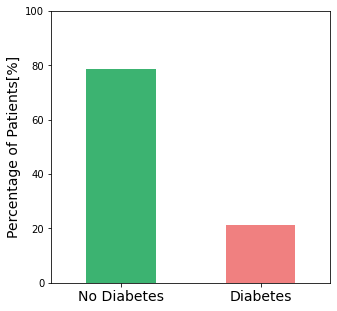

In [2]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
(train_df.diabetes_mellitus.value_counts(normalize=True)*100).plot(kind='bar',
                                                                   color=['mediumseagreen', 'lightcoral'])
ax.set_ylim([0, 100])
ax.set_ylabel('Percentage of Patients[%]', fontsize=14)
ax.set_xticklabels(['No Diabetes', 'Diabetes'], fontsize=14, rotation=0)
plt.show()

# Data Cleaning

## Identifiers
There are 204 unique `hospital_id` in the training data and 190 in the test data. The `hospital_id` in the training and the testing data are disjunct - meaning that none of the `hospital_id`  in the training data are in the testing data and vice versa. The `hospital_id` in the training data range from 1 to 204 while they range from 10001 to 10199 in the testing data. We could check whether `hospital_id` 1 would correspond to `hospital_id` 10001 in testing data. However, since intuitively the `hospital_id` is not a relevant feature whether a patient has been diagnosed with diabetes before, we will not analyse this further. Therefore, **`hospital_id` should probably be not included in the final features.**

We will drop the id related columns since they intuitively have nothing to do with whether a patient has diabetes or not.

In [3]:
id_cols = ['encounter_id', 'hospital_id', 'icu_id']

train_df.drop(id_cols, axis=1, inplace=True)
test_df.drop(id_cols, axis=1, inplace=True)

## Vitals

There are 32 vital sign and blood work related variables that are measured. Each variable has a minimum and a maxmimum value over the timespan of the first hour and the first 24 hours after being admitted to the ICU. Therefore, there are four measures to each variable (`h1_[...]_min`, `h1_[...]_max`,`d1_[...]_min`,`d1_[...]_max`). This results in a total of 128 (32x4) variables related to vital signs and blood work.

From below plot we can see that the **measurements from the first hour have a lot more missing values** than the measurements taken in the first 24 hours.

Furthermore, there are three blood pressure related variables (`diasbp`, `mbp`, `sysbp`) which each have two additional columns (`[...]_invasive` and `[...]_noninvasive`). For these variables **all invasively measured columns have a high rate of missing values**.

In [4]:
vitals = [((v.split("d1_")[1]).split("_min")[0]) for v in train_df.columns[train_df.columns.str.startswith('d1') & train_df.columns.str.endswith('min')]]

vitals_cols = []
vitals_cols_h1_min = []
vitals_cols_h1_max = []
vitals_cols_d1_min = []
vitals_cols_d1_max = []

for v in vitals:
    vitals_cols.append(v)
    vitals_cols_h1_min.append(f"h1_{v}_min")
    vitals_cols_h1_max.append(f"h1_{v}_max")
    vitals_cols_d1_min.append(f"d1_{v}_min")
    vitals_cols_d1_max.append(f"d1_{v}_max")

temp = pd.DataFrame({'vitals' : vitals_cols,
                    'h1_min' : train_df[vitals_cols_h1_min].isna().sum(axis=0).values,
                     'h1_max' : train_df[vitals_cols_h1_max].isna().sum(axis=0).values,
                     'd1_min' : train_df[vitals_cols_d1_min].isna().sum(axis=0).values,
                     'd1_max' : train_df[vitals_cols_d1_max].isna().sum(axis=0).values,
                    }).set_index('vitals')

temp

,h1_min,h1_max,d1_min,d1_max
vitals,,,,
diasbp_invasive,104829,104829,95068,95068
diasbp,5527,5527,277,277
diasbp_noninvasive,11339,11339,1636,1636
heartrate,4074,4074,262,262
mbp_invasive,104766,104766,94868,94868
mbp,6530,6530,327,327
mbp_noninvasive,13297,13297,2228,2228
resprate,6454,6454,683,683
spo2,6242,6242,532,532


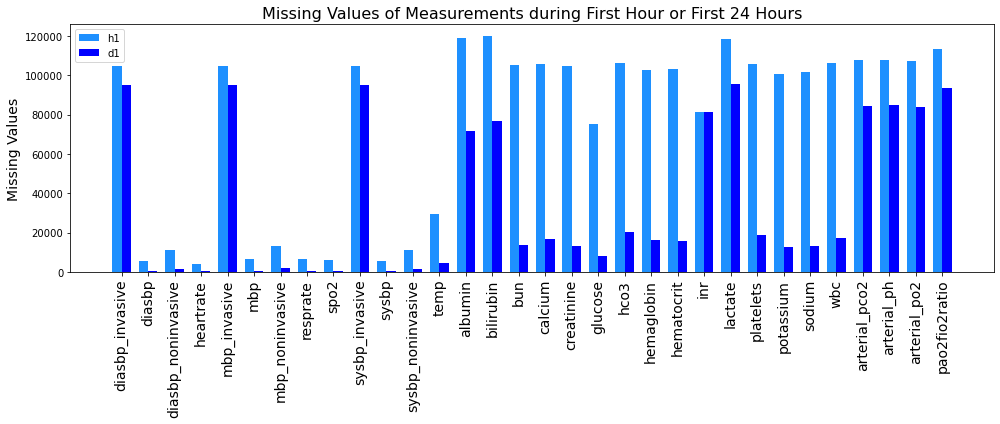

In [5]:
x = np.arange(len(temp.h1_min))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
rects1 = ax.bar(x - width/2, temp.h1_min, width, label='h1', color='dodgerblue')
rects1 = ax.bar(x + width/2, temp.d1_min, width, label='d1', color='blue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Missing Values', fontsize=14)
ax.set_title('Missing Values of Measurements during First Hour or First 24 Hours', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(temp.index, rotation=90,  fontsize=14)
ax.legend()

fig.tight_layout()

plt.show();

In [6]:
drop_columns = train_df.columns[train_df.columns.str.startswith('h1') | train_df.columns.str.contains('invasive')]

train_df.drop(drop_columns, axis=1, inplace=True)
test_df.drop(drop_columns, axis=1, inplace=True)

We will drop the `h1` columns due to their high rate of missing values and their redundancy with the `d1` values. Additionally, we will drop the `invasive`/`noninvasive` columns for `diasbp`, `sysbp`, and `mpb` for the same reason. The droppend columns could not be used to fill missing values in the redundant columns because if the `d1` is NaN, the `h1`column is NaN as well.

After dropping the `h1` columns and the `invasive`/`noninvasive` columns, we are now have the following rate of missing values:

* There are 103 feature columns and 1 target column
* 18% (19/104) of columns have no missing values
* `weight` and `bmi` have a higher rate of missing values in the test data (`bmi` is calculated from `weight`)
* `age` only has missing data in the training data

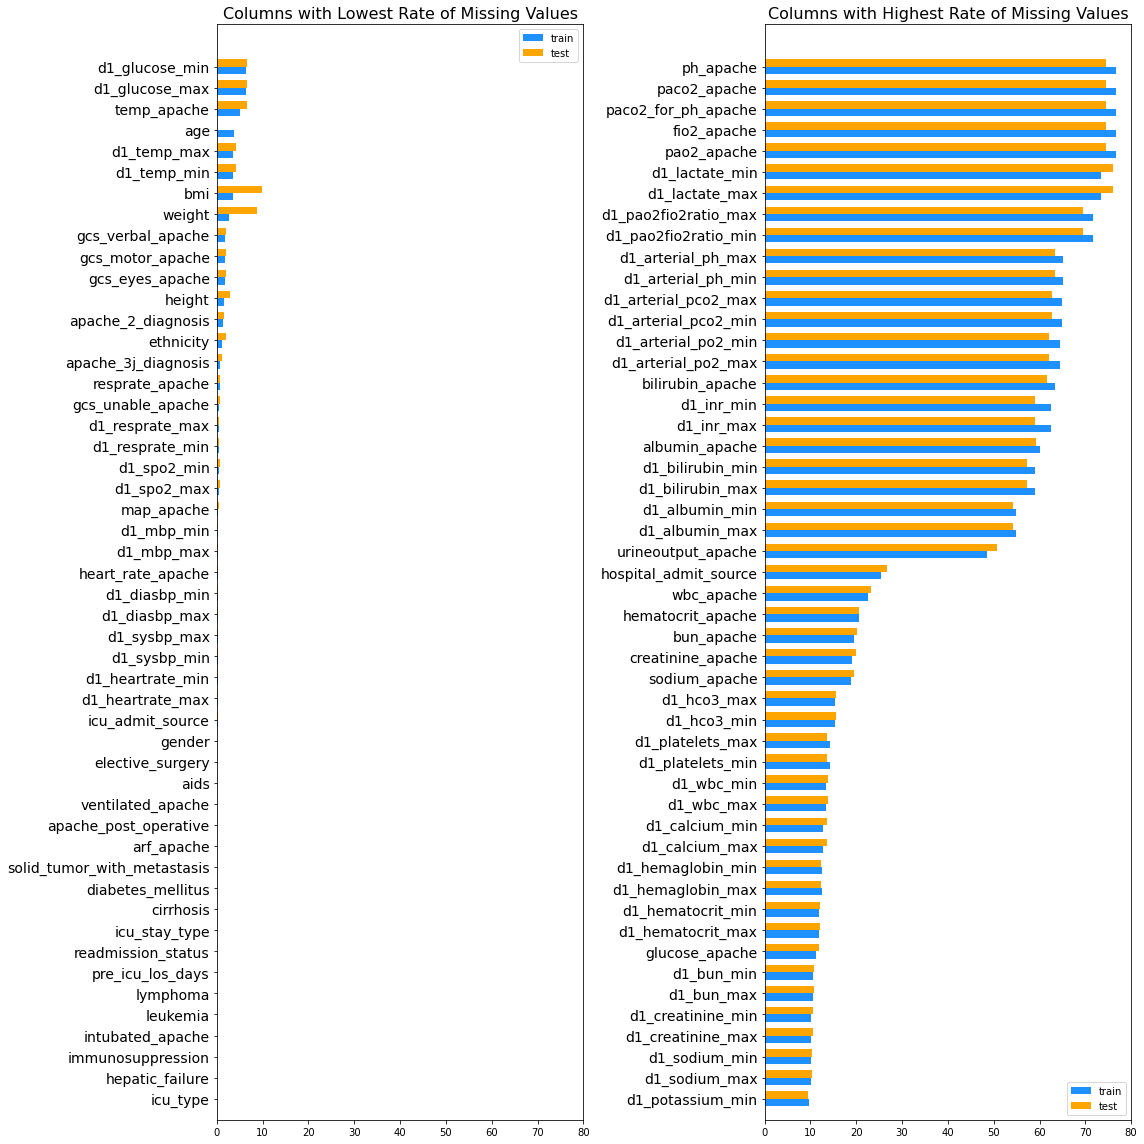

In [7]:
missing_data = pd.DataFrame({'train' : train_df.isna().sum(axis=0) /len(train_df)*100,
                             'test' : test_df.isna().sum(axis=0) /len(test_df)*100})
missing_data = missing_data.sort_values(by='train', ascending=True)

# Visualize
split_length= int(len(missing_data)/2)
x = np.arange(split_length)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
rects1 = ax[0].barh(x - width/2, missing_data.head(split_length).train, width, label='train', color='dodgerblue')
rects1 = ax[0].barh(x + width/2, missing_data.head(split_length).test, width, label='test', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_title('Columns with Lowest Rate of Missing Values', fontsize=16)
ax[0].set_yticks(x)
ax[0].set_ylim([-1, split_length+1])
ax[0].set_xlim([0, 80])
ax[0].set_yticklabels(missing_data.head(split_length).index, rotation=0,  fontsize=14)
ax[0].legend()

rects1 = ax[1].barh(x - width/2, missing_data.tail(split_length).train, width, label='train', color='dodgerblue')
rects1 = ax[1].barh(x + width/2, missing_data.tail(split_length).test, width, label='test', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[1].set_title('Columns with Highest Rate of Missing Values', fontsize=16)
ax[1].set_yticks(x)
ax[1].set_ylim([-1, split_length+1])
ax[1].set_xlim([0, 80])
ax[1].set_yticklabels(missing_data.tail(split_length).index, rotation=0,  fontsize=14)
ax[1].legend()

fig.tight_layout()

plt.show()

## Readmission Status

Furthermore, we will drop the column `readmission_status` because it only has one unique value of 0.

In [8]:
print(train_df['readmission_status'].unique())
print(test_df['readmission_status'].unique())

# Drop readmission_status column
train_df.drop("readmission_status", axis=1, inplace=True)
test_df.drop("readmission_status", axis=1, inplace=True)

[0]
[0]


## Implausible Age
We are working with data from **young adults and adults aging 16 and older**. However, in the training data, there are 30 data points with `age = 0`. For the initial analysis purposes, we will drop these data points because they have on average have twice as many NaN values then the average data point. Usually, dropping data is not recommended. However, these data points only account for 0.02% of data loss in addition to the earlier argument.

(Unhide the code and output to see the reference calculations -->)

In [9]:
print(f"There are {len(train_df[train_df.age<16])} data points in the training data set with age = 0.")
print(f"There are {len(test_df[test_df.age<16])} data points in the training data set with age = 0.")

print(f"On average {np.round(((train_df.isna().sum(axis=1)/180).mean()*100), 2)}% of the data is NaN.")
print(f"The data point to be dropped have a NaN rate of {np.round(((train_df[train_df.age<16].isna().sum(axis=1)/180).mean()*100), 2)}%.")

print(f"Dropping {len(train_df[train_df.age<16])} data points from a total of {len(train_df)} data points equals a loss of {np.round((len(train_df[train_df.age<16])/len(train_df)*100), 2)}% of the training data.")

display(train_df[train_df.age<16])

There are 30 data points in the training data set with age = 0.
There are 0 data points in the training data set with age = 0.
On average 11.2% of the data is NaN.
The data point to be dropped have a NaN rate of 37.91%.
Dropping 30 data points from  a total of 130157 data points equals a loss of 0.02% of the training data.


,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,...,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
10394,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,admit,Med-Surg ICU,...,NaN,NaN,0,0,0,0,0,0,0,0
10953,0.0,NaN,0,NaN,NaN,165.1,NaN,NaN,readmit,Med-Surg ICU,...,NaN,NaN,0,0,0,0,0,0,0,0
12376,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,admit,Med-Surg ICU,...,NaN,NaN,0,0,0,0,0,0,0,0
12538,0.0,34.561404,0,NaN,M,170.1,NaN,Accident & Emergency,admit,Med-Surg ICU,...,114.0,114.000000,0,0,0,0,0,0,0,0
13298,0.0,26.162761,0,African American,F,157.5,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,NaN,NaN,0,0,0,0,0,0,0,0
14122,0.0,21.342855,0,NaN,F,193.0,NaN,Floor,admit,Med-Surg ICU,...,NaN,NaN,0,0,0,0,0,0,0,1
25765,0.0,NaN,0,Caucasian,M,NaN,Emergency Department,Accident & Emergency,admit,CSICU,...,472.5,436.666667,0,0,0,0,0,0,0,0
34590,0.0,16.700592,0,NaN,NaN,162.5,NaN,Operating Room / Recovery,admit,CCU-CTICU,...,NaN,NaN,0,0,0,0,0,0,0,0
35300,0.0,42.657614,0,NaN,NaN,182.9,Recovery Room,Operating Room / Recovery,admit,CCU-CTICU,...,NaN,NaN,0,0,0,0,0,0,0,0
35429,0.0,34.068435,0,NaN,NaN,177.8,Operating Room,Operating Room / Recovery,admit,CCU-CTICU,...,NaN,NaN,0,0,0,0,0,0,0,0


In [10]:
# Drop data with implausible age (test data has no implausible age)
train_df = train_df[train_df.age >= 16].reset_index(drop=True)

# Handling Missing Values


## Vitals
We can also see that there are columns with similar names, such as e.g. `glucose_apache` and `d1_glucose_min`/`d1_glucose_max`.
According to the data dictionary, the `_apache` variables are:
> [...] measured during the first 24 hours which results in the highest APACHE III score

and the `d1_..._max` and `d1_..._min` variable are:
> The [lowested/highest ...] concentration of the patient [...] during the first 24 hours of their unit stay

Therefore, we could assume that the `_apache` and the `d1_..._max` values should be similar to each other.

The variables for which we seem to have multiple columns are: 
* `albumin`:
* `bilirubin`:
* `bun`: blood urea nitrogen
* `creatinine`:
* `glucose`: 
* `hematocrit`: volume proportion of red blood cells in blood
* `resprate`: respiratory rate
* `sodium`:
* `temp`: patient's core temperature
* `wbc`: white blood cell count
* `heart_rate`

We can see that the `d1_...max` value is equal to the `..._apache` value for more than 50% of the non NaN values for the above variables except `resprate` and `temp`. Therefore, we can **merge the `d1_...max` and the `..._apache` columns to one**.

In [11]:
apache_cols = train_df.columns[train_df.columns.str.contains('apache')]
apache_cols = [c.split('_apache')[0] for c in apache_cols] 

vital_cols = train_df.columns[train_df.columns.str.startswith('d1') & train_df.columns.str.contains('_max')]
vital_cols = [(c.split('d1_')[1]).split('_max')[0] for c in vital_cols]

common_cols = [c for c in apache_cols if c in vital_cols]

for c in common_cols:
    var1 = f"d1_{c}_max"
    var2 = f"{c}_apache"
    notna_condition = train_df[var1].notna() & train_df[var2].notna()
    notna_condition_test = test_df[var1].notna() & test_df[var2].notna()

    print(f"{c} has {np.round((train_df[notna_condition][var2]==(train_df[notna_condition][var1])).sum()/len(train_df[notna_condition])*100,2)}% duplicates in the training data")
    print(f"{c} has {np.round((test_df[notna_condition_test][var2]==(test_df[notna_condition_test][var1])).sum()/len(test_df[notna_condition_test])*100,2)}% duplicates in the testing data")

albumin has 82.04% duplicates in the training data
albumin has 80.62% duplicates in the testing data
bilirubin has 95.12% duplicates in the training data
bilirubin has 95.05% duplicates in the testing data
bun has 89.24% duplicates in the training data
bun has 88.77% duplicates in the testing data
creatinine has 75.4% duplicates in the training data
creatinine has 74.55% duplicates in the testing data
glucose has 55.5% duplicates in the training data
glucose has 56.42% duplicates in the testing data
hematocrit has 57.0% duplicates in the training data
hematocrit has 54.11% duplicates in the testing data
resprate has 19.65% duplicates in the training data
resprate has 18.06% duplicates in the testing data
sodium has 61.66% duplicates in the training data
sodium has 61.36% duplicates in the testing data
temp has 8.4% duplicates in the training data
temp has 10.54% duplicates in the testing data
wbc has 77.14% duplicates in the training data
wbc has 74.66% duplicates in the testing data


In [12]:

for c in common_cols:
    if c not in ['resprate', 'temp']:
        # Fill empty d1_..._max column from available ..._apache column
        train_df[f"d1_{c}_max"] = np.where((train_df[f"d1_{c}_max"].isna() 
                                            & train_df[f"{c}_apache"].notna()), 
                                           train_df[f"{c}_apache"], 
                                           train_df[f"d1_{c}_max"])
        
        test_df[f"d1_{c}_max"] = np.where((test_df[f"d1_{c}_max"].isna() 
                                           & test_df[f"{c}_apache"].notna()), 
                                           test_df[f"{c}_apache"], 
                                           test_df[f"d1_{c}_max"])
        # Drop ..._apache column
        train_df.drop(f"{c}_apache", axis=1, inplace=True)
        test_df.drop(f"{c}_apache", axis=1, inplace=True)
        
# Fill empty d1_heartrate_max column from available heart_rate_apache column
train_df["d1_heartrate_max"] = np.where((train_df["d1_heartrate_max"].isna() 
                                    & train_df["heart_rate_apache"].notna()), 
                                   train_df["heart_rate_apache"], 
                                   train_df["d1_heartrate_max"])

test_df["d1_heartrate_max"] = np.where((test_df["d1_heartrate_max"].isna() 
                                    & test_df["heart_rate_apache"].notna()), 
                                   test_df["heart_rate_apache"], 
                                   test_df["d1_heartrate_max"])
# Drop ..._apache column
train_df.drop("heart_rate_apache", axis=1, inplace=True)
test_df.drop("heart_rate_apache", axis=1, inplace=True)

In [13]:
common_cols = [f"d1_{c}_max" for c in common_cols if c not in ['resprate', 'temp']]

missing_data = missing_data.T
missing_data[common_cols]
display(missing_data[common_cols].style.set_caption('Percentage of Missing Vaues before Merge with _apache columns'))

missing_data_ = pd.DataFrame({'train' : train_df.isna().sum(axis=0) /len(train_df)*100,
                             'test' : test_df.isna().sum(axis=0) /len(test_df)*100})
missing_data_ = missing_data_.sort_values(by='train', ascending=True).T

display(missing_data_[common_cols].style.set_caption('Percentage of Missing Vaues after Merge with _apache columns'))

,d1_albumin_max,d1_bilirubin_max,d1_bun_max,d1_creatinine_max,d1_glucose_max,d1_hematocrit_max,d1_sodium_max,d1_wbc_max
train,54.861437,58.955723,10.551872,10.197684,6.333121,11.976306,10.195379,13.390751
test,54.133281,57.260113,10.826656,10.660543,6.654290,12.008990,10.416260,13.894860


,d1_albumin_max,d1_bilirubin_max,d1_bun_max,d1_creatinine_max,d1_glucose_max,d1_hematocrit_max,d1_sodium_max,d1_wbc_max
train,53.825746,57.729405,9.712400,9.345608,5.820727,11.006960,9.363987,12.315905
test,53.234317,56.038695,10.142662,9.986320,6.273207,11.315224,9.781122,13.152238


## Weight and Height
Let's first have a quick look at the height and weight distributions according to the gender. We can see that males are on average taller and heavier than females - this is probably not news to you. However, looking at the distributions, we can also see that the weights and the heights are limited to a certain range:
* Height: [137.2, 195.59] cm
* Weight: [38.6, 186] kg


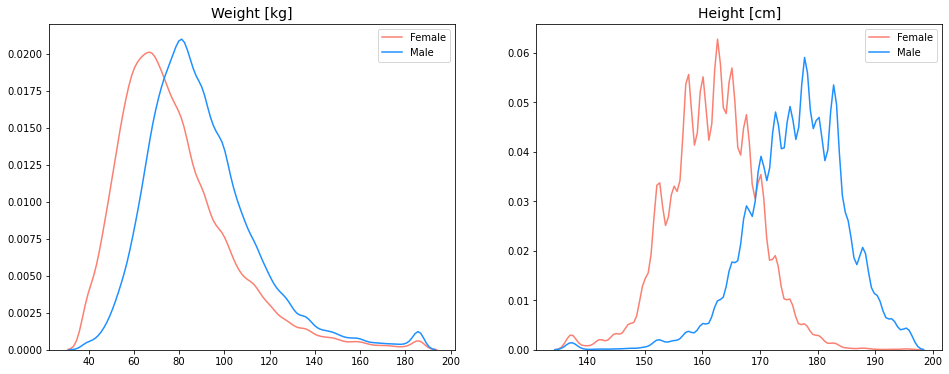

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.kdeplot(train_df[train_df.gender == 'F'].weight, label='Female', color='salmon', ax=ax[0])
sns.kdeplot(train_df[train_df.gender == 'M'].weight, label='Male', color='dodgerblue', ax=ax[0])
ax[0].set_title('Weight [kg]', fontsize=14)

sns.kdeplot(train_df[train_df.gender == 'F'].height, label='Female', color='salmon', ax=ax[1])
sns.kdeplot(train_df[train_df.gender == 'M'].height, label='Male', color='dodgerblue', ax=ax[1])
ax[1].set_title('Height [cm]', fontsize=14)

plt.show()

The `height` column has 1.6% missing values in the training data and 2.9% missing values in the testing data.
The `weight` column has 2.6% missing values in the training data and 8.9% missing values in the testing data.

We will **fill the missing values with the mean values according to the gender**.

In [15]:
print(train_df.height.isna().sum(axis=0)/len(train_df)*100)
print(train_df.weight.isna().sum(axis=0)/len(train_df)*100)

print(test_df.height.isna().sum(axis=0)/len(test_df)*100)
print(test_df.weight.isna().sum(axis=0)/len(test_df)*100)

display(train_df.groupby('gender')['weight', 'height'].mean())
display(test_df.groupby('gender')['weight', 'height'].mean())

1.568655654911738
2.639464915014504
2.941176470588235
8.872386163767834


,weight,height
gender,,
F,77.877822,161.811127
M,89.910228,176.423172


,weight,height
gender,,
F,77.112713,161.534660
M,88.836120,175.836729


In [16]:
train_df["height"] = np.where((train_df.height.isna() & (train_df.gender == 'F')), 
                              162, train_df["height"])
train_df["height"] = np.where((train_df.height.isna() & (train_df.gender == 'M')), 
                              176, train_df["height"])
train_df["height"] = np.where((train_df.height.isna() & (train_df.gender.isna())), 
                              169, train_df["height"])
train_df["weight"] = np.where((train_df.height.isna() & (train_df.gender == 'F')), 
                              78, train_df["weight"])
train_df["weight"] = np.where((train_df.height.isna() & (train_df.gender == 'M')), 
                              89, train_df["weight"])
train_df["weight"] = np.where((train_df.height.isna() & (train_df.gender.isna())), 
                              84, train_df["weight"])

test_df["height"] = np.where((test_df.height.isna() & (test_df.gender == 'F')), 
                             162, test_df["height"])
test_df["height"] = np.where((test_df.height.isna() & (test_df.gender == 'M')), 
                             176, test_df["height"])
test_df["height"] = np.where((test_df.height.isna() & (test_df.gender.isna())), 
                              169, test_df["height"])
test_df["weight"] = np.where((test_df.height.isna() & (test_df.gender == 'F')), 
                             78, test_df["weight"])
test_df["weight"] = np.where((test_df.height.isna() & (test_df.gender == 'M')), 
                             89, test_df["weight"])
test_df["weight"] = np.where((test_df.height.isna() & (test_df.gender.isna())), 
                              84, test_df["weight"])

## Oxygenation Index

The **oxigenation index or Horowitz index** is the ratio of partial pressure of oxygen in blood (PaO2) and the fraction of oxygen in the inhaled air (FiO2). Therefore, we can fill the missing values of `d1_pao2fio2ratio_max` with `pao2_apache`/`fio2_apache`.

In [17]:
train_df["d1_pao2fio2ratio_max"] = np.where((train_df["pao2_apache"].notna() 
                                             & train_df["fio2_apache"].notna()
                                             & train_df["d1_pao2fio2ratio_max"].isna() ), 
                                            train_df["pao2_apache"] / train_df["fio2_apache"], 
                                            train_df["d1_pao2fio2ratio_max"])

test_df["d1_pao2fio2ratio_max"] = np.where((test_df["pao2_apache"].notna() 
                                             & test_df["fio2_apache"].notna()
                                             & test_df["d1_pao2fio2ratio_max"].isna() ), 
                                            test_df["pao2_apache"] / test_df["fio2_apache"], 
                                            test_df["d1_pao2fio2ratio_max"])


## Gender
We will fill the missing values for the `gender` with 'Unknown' and for `ethnicity` with the already available value 'Other/Unknown'.

In [18]:
train_df["gender"] = train_df["gender"].fillna("Unknown")
train_df["ethnicity"] = train_df["gender"].fillna("Other/Unknown")

test_df["gender"] = test_df["gender"].fillna("Unknown")
test_df["ethnicity"] = test_df["gender"].fillna("Other/Unknown")

# Feature Engineering

## Weight, Height, and Body Mass Index (BMI)
The Body Mass Index (BMI) is a metric to indicate how a persons weight is in relation to their height and is calculated as follows: $\text{BMI} = \dfrac{\text{weight}}{\text{height}^2}$

Since we have the patients' height and weight, we can do a quick sanity check of the BMI data.
We can see that there are 7114 cases in the training data that cause deviations from the expected values due to the limiting of the weight and the height data.

In [19]:
train_df["bmi_calc"] = np.round(train_df.weight / ((train_df.height/100)**2), 8)
test_df["bmi_calc"] = np.round(test_df.weight / ((test_df.height/100)**2), 8)

In [20]:
# temp[temp.bmi.notna() & (abs(temp.bmi.round(2) - temp.bmi_calc.round(2)) > 10)].head()
train_df[train_df.bmi.notna() & (train_df.bmi != train_df.bmi_calc)]

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,...,d1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus,bmi_calc
46,59.0,14.844926,0,F,F,170.2,Floor,Floor,admit,Med-Surg ICU,...,147.500000,0,0,0,0,0,0,1,0,13.566676
80,85.0,35.879362,1,F,F,165.1,Operating Room,Operating Room / Recovery,admit,CTICU,...,120.000000,0,0,0,0,0,0,0,0,35.879362
86,78.0,39.114757,1,M,M,175.3,Operating Room,Operating Room / Recovery,admit,Med-Surg ICU,...,NaN,0,0,0,0,0,0,0,0,39.114757
118,36.0,30.160706,0,M,M,188.0,Emergency Department,Floor,admit,Med-Surg ICU,...,196.363636,0,1,0,0,0,0,0,0,30.160706
133,72.0,22.079636,1,M,M,177.8,Operating Room,Operating Room / Recovery,admit,Med-Surg ICU,...,NaN,0,0,0,0,0,0,0,1,22.079636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125113,27.0,67.814990,1,F,F,165.1,Operating Room,Operating Room / Recovery,admit,SICU,...,278.571429,0,0,0,0,0,0,0,1,68.236823
125125,59.0,35.879362,0,M,M,165.1,NaN,Floor,admit,Cardiac ICU,...,NaN,0,0,0,0,0,0,0,1,35.879362
125126,51.0,14.844926,0,M,M,180.3,Direct Admit,Other Hospital,admit,MICU,...,185.000000,0,0,0,0,0,0,0,0,12.058537
125131,66.0,28.823381,1,F,F,157.5,Floor,Operating Room / Recovery,admit,CTICU,...,380.000000,0,0,0,0,0,0,0,0,28.823381


According to the BMI, we can classify the following categories:
* Underweight: < 18.5
* Healthy weight: 18.5 to 25
* Overweight: 25 to 30
* Obese: > 30

From below plot we can see that there are some data points which are categorized as obses although their height and weight indicate underweight. We will have to analyse them in depth.

In [21]:
def get_bmi_category(bmi):
    
    if bmi != bmi: # NaN
        return np.nan
    elif bmi < 18.5: # Underweight
        return -1
    elif bmi < 25: # Healthy weight
        return 0
    elif bmi < 30: # Overweight
        return 1
    else: # Obese
        return 2

train_df["bmi_cat"] = train_df["bmi"].apply(get_bmi_category)
test_df["bmi_cat"] = test_df["bmi"].apply(get_bmi_category)

# Only reconstruct weight if height is not also capped
train_df["weight_rec"] = np.where((((train_df.weight == 38.6) | (train_df.weight == 38.6)) 
                                   & ((train_df.height != 137.20) & (train_df.height != 195.59)) 
                                   & (train_df.bmi != train_df.bmi_calc)), 
                                  train_df.bmi * ((train_df.height/100)**2), 
                                  train_df["weight"])

test_df["weight_rec"] = np.where((((test_df.weight == 38.6) | (test_df.weight == 38.6)) 
                                   & ((test_df.height != 137.20) & (test_df.height != 195.59)) 
                                   & (test_df.bmi != test_df.bmi_calc)), 
                                  test_df.bmi * ((test_df.height/100)**2), 
                                  test_df["weight"])

# Only reconstruct height if weight is not also capped
train_df["height_rec"] = np.where((((train_df.weight != 38.6) & (train_df.weight != 38.6)) 
                                   & ((train_df.height == 137.20) | (train_df.height == 195.59)) 
                                   & (train_df.bmi != train_df.bmi_calc)), 
                                  np.sqrt(train_df.weight / train_df.bmi)*100,
                                  train_df["height"])

test_df["height_rec"] = np.where((((test_df.weight != 38.6) & (test_df.weight != 38.6)) 
                                   & ((test_df.height == 137.20) | (test_df.height == 195.59)) 
                                   & (test_df.bmi != test_df.bmi_calc)), 
                                  np.sqrt(test_df.weight / test_df.bmi)*100,
                                  test_df["height"])

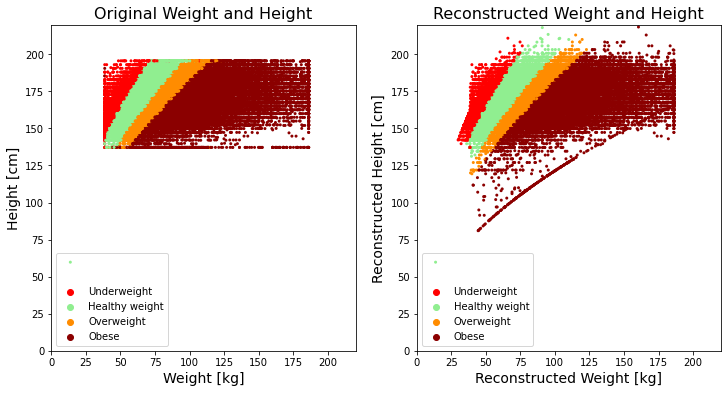

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.scatterplot(x=train_df.weight, y=train_df.height, hue=train_df.bmi_cat, palette=['red', 'lightgreen', 'darkorange', 'darkred'], linewidth=0, marker='.', ax=ax[0])
ax[0].set_title('Original Weight and Height', fontsize=16)
ax[0].set_xlabel('Weight [kg]', fontsize = 14)
ax[0].set_ylabel('Height [cm]', fontsize = 14)

sns.scatterplot(x=train_df.weight_rec, y=train_df.height_rec, hue=train_df.bmi_cat, palette=['red', 'lightgreen', 'darkorange', 'darkred'], linewidth=0, marker='.', ax=ax[1])
ax[1].set_title('Reconstructed Weight and Height', fontsize=16)
ax[1].set_xlabel('Reconstructed Weight [kg]', fontsize = 14)
ax[1].set_ylabel('Reconstructed Height [cm]', fontsize = 14)

for i in range(2):
    ax[i].set_xlim([0, 220])
    ax[i].set_ylim([0, 220])
    ax[i].legend(['', '', 'Underweight', 'Healthy weight', 'Overweight', 'Obese'])

plt.show()

# Replace height and weight with reconstructed values
train_df["height"] = train_df["height_rec"]
train_df["weight"] = train_df["weight_rec"]

test_df["height"] = test_df["height_rec"]
test_df["weight"] = test_df["weight_rec"]

# Drop temporary helper columns
train_df.drop(['height_rec', 'weight_rec', 'bmi_calc'], axis=1, inplace=True)
test_df.drop(['height_rec', 'weight_rec', 'bmi_calc'], axis=1, inplace=True)

According to the WHO diabetes fact sheet [2], maintaining a normal body weight is one of the ways to prevent or delay the onset of type 2 diabetes. If we plot plot the percentage of patients with diabetes over the BMI category as below, we can see a strong correlation. While 15% of patients with a healthy weight have diabetes, twice as many patients in the obese category have diabetes.

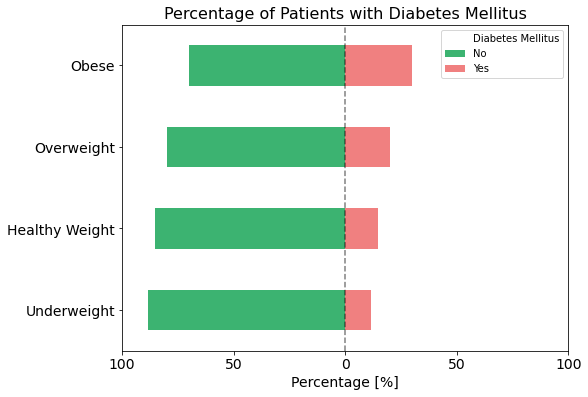

In [23]:
# Prepare temporary dataframe for visualization
temp = (train_df.groupby(['bmi_cat']).diabetes_mellitus.value_counts(normalize=True)*100).to_frame()
temp.columns = ['percentage']
temp.reset_index(inplace=True)
temp = temp.pivot(index='bmi_cat', columns = 'diabetes_mellitus')['percentage']
temp.insert(0, '', 100 - temp[0])

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
temp.plot.barh(stacked=True, color=['white', 'mediumseagreen', 'lightcoral'], edgecolor='none', legend=True, ax=ax)
ax.legend(['Diabetes Mellitus', 'No', 'Yes'], loc='upper right')
ax.axvline(100, linestyle='--', color='black', alpha=.5)
ax.set_zorder(-100)

plt.xlim(0, 200)
xvalues = range(0,201, 50)
xlabels = ['100', '50', '0', '50', '100']
plt.xticks(xvalues, xlabels)
plt.yticks([0, 1, 2, 3], ['Underweight', 'Healthy Weight', 'Overweight', 'Obese'])

ax.set_xlabel('Percentage [%]', fontsize=14)
ax.set_ylabel('', fontsize=14)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

    ax.set_title("Percentage of Patients with Diabetes Mellitus", fontsize=16)
plt.show()

## Vitals

The vitals have a minimum and a maximum values form the first 24 hours. From the values we can create some additional features: **range and mean**.

In [24]:
vitals = pd.Series(vitals)[~pd.Series(vitals).str.contains('invasive')].values

for v in vitals:
    train_df[f'd1_{v}_range'] = train_df[f'd1_{v}_max'] - train_df[f'd1_{v}_min']
    train_df[f'd1_{v}_mean'] = (train_df[f'd1_{v}_max'] + train_df[f'd1_{v}_min']) / 2

    test_df[f'd1_{v}_range'] = test_df[f'd1_{v}_max'] - test_df[f'd1_{v}_min']
    test_df[f'd1_{v}_mean'] = (test_df[f'd1_{v}_max'] + test_df[f'd1_{v}_min']) / 2

## Blood Pressure

A patient's blood pressure level can be categorized according to the systolic and diastolic blood pressure.

In [25]:
def get_blood_pressure_category(sysbp, diasbp):
    if ((sysbp < 90) & (diasbp < 60)):
        return -1 # Low blood pressure
    elif ((sysbp < 120) & (diasbp < 80)):
        return 0 # Normal
    elif ((sysbp < 140) & (diasbp < 90)):
        return 1 # Pre-Hypertension
    elif ((sysbp < 160) & (diasbp < 100)):
        return 2 # Stage 1 Hypertension
    else:
        return 3 # Stage 2 Hypertension
    
train_df['bp_cat'] = train_df[['d1_sysbp_mean', 'd1_diasbp_mean']].apply(lambda x: get_blood_pressure_category(x.d1_sysbp_mean, x.d1_diasbp_mean), axis=1)
test_df['bp_cat'] = test_df[['d1_sysbp_mean', 'd1_diasbp_mean']].apply(lambda x: get_blood_pressure_category(x.d1_sysbp_mean, x.d1_diasbp_mean), axis=1)

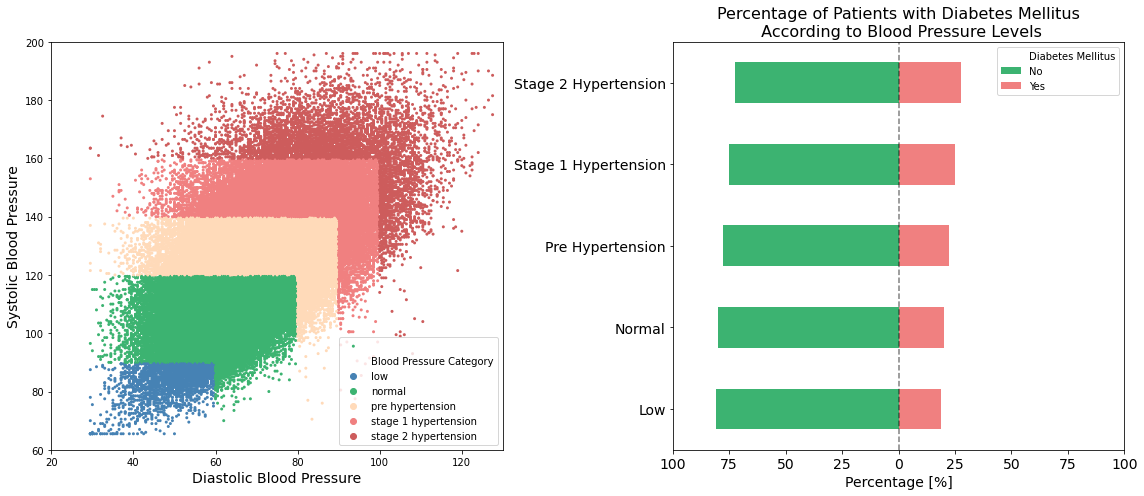

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

sns.scatterplot(y=train_df.d1_sysbp_mean, 
                x=train_df.d1_diasbp_mean, 
                hue=train_df.bp_cat, 
                palette=['steelblue', 'mediumseagreen', 'peachpuff', 'lightcoral', 'indianred'], 
                linewidth=0, 
                marker='.', 
                color='grey',
               ax=ax[0])
ax[0].set_xlim([20,130])
ax[0].set_ylim([60,200])
ax[0].set_xlabel('Diastolic Blood Pressure', fontsize=14)
ax[0].set_ylabel('Systolic Blood Pressure', fontsize=14)
ax[0].legend(['', 'Blood Pressure Category', 'low', 'normal', 'pre hypertension', 'stage 1 hypertension', 'stage 2 hypertension'])


# Prepare temporary dataframe for visualization
temp = (train_df.groupby(['bp_cat']).diabetes_mellitus.value_counts(normalize=True)*100).to_frame()
temp.columns = ['percentage']
temp.reset_index(inplace=True)
temp = temp.pivot(index='bp_cat', columns = 'diabetes_mellitus')['percentage']
temp.insert(0, '', 100 - temp[0])

# Plot
temp.plot.barh(stacked=True, color=['white', 'mediumseagreen', 'lightcoral'], edgecolor='none', legend=True, ax=ax[1])
ax[1].legend(['Diabetes Mellitus', 'No', 'Yes'], loc='upper right')
ax[1].axvline(100, linestyle='--', color='black', alpha=.5)
ax[1].set_zorder(-100)

ax[1].set_xlim(0, 200)
ax[1].set_xticklabels(['100', '75', '50','25', '0','25', '50', '75','100'])
ax[1].set_yticklabels(['Low', 'Normal', 'Pre Hypertension', 'Stage 1 Hypertension', 'Stage 2 Hypertension'])


ax[1].set_xlabel('Percentage [%]', fontsize=14)
ax[1].set_ylabel('', fontsize=14)

for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax[1].set_title("Percentage of Patients with Diabetes Mellitus\n According to Blood Pressure Levels", fontsize=16)
plt.tight_layout()
plt.show()


## Glasgow Coma Scale
The Glasgow Coma Scale (GCS) is a metric to measure a person's level of consciousness. It is based on the person's eye response, verbal response and motor response and ranges from 0 (unconscious) to 15 (fully conscious).

In [27]:
train_df["gcs_sum_apache"] = train_df[['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']].sum(axis=1)
test_df["gcs_sum_apache"] = test_df[['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']].sum(axis=1)

# Exploratory Data Analysis (EDA)

According to the American Diabetes Association (ADA), glucose levels are used to diagnose diabetes. Since blood sugar levels can highly vary according to meal intake, **Fasting Plasma Glucose (FPG) tests** are most reliable. That means the patients has not eaten or drank anything except water for the past 8 hours. However, this data is not available in the provided dataset. Another possible test to diagnose severe diabetes symptoms is the **Casual Plasma Glucose test**. In this case, diabetes is diagnosed if the blood sogar is greater or equal to 200mg/dl [1].

Based on the minimum, maximum, mean, and range of the glucose levels measured within the first 24 hours, we can already see quite a distinction between patients with diabetes and patients with no diabetes.

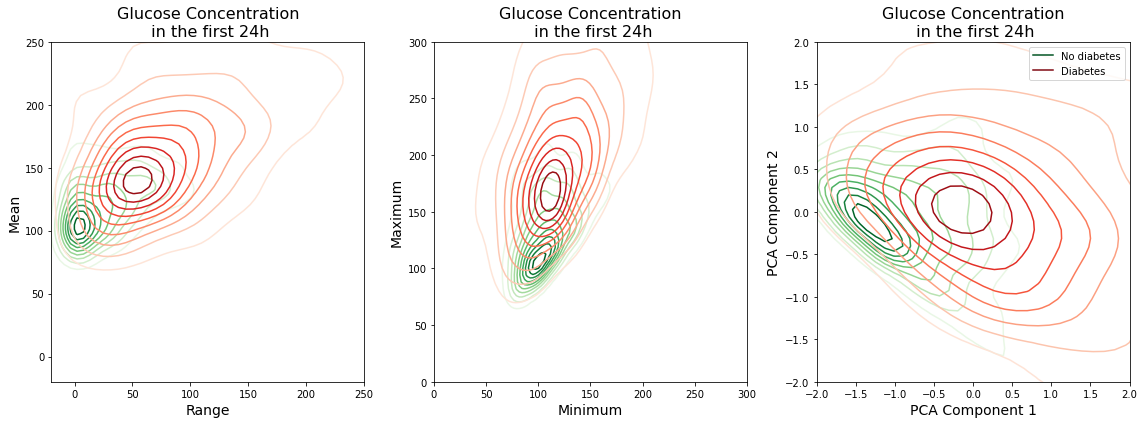

In [28]:
no_diabetes = train_df[train_df.bmi.notna() & train_df.d1_glucose_mean.notna() & (train_df.diabetes_mellitus == 0)].head(1000) # only use first 1000 samples for fast visualization (this is not a 100% accurate respresentation)
diabetes = train_df[train_df.bmi.notna() & train_df.d1_glucose_mean.notna() & (train_df.diabetes_mellitus == 1)].head(1000) # only use first 1000 samples for fast visualization (this is not a 100% accurate respresentation)

# Set up the figure
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

# Draw the two density plots
sns.kdeplot(no_diabetes.d1_glucose_range, no_diabetes.d1_glucose_mean, cmap="Greens", label='No diabetes', ax=ax[0])
sns.kdeplot(diabetes.d1_glucose_range, diabetes.d1_glucose_mean, cmap="Reds", label='Diabetes', ax=ax[0])
ax[0].set_xlim([-20, 250])
ax[0].set_ylim([-20, 250])

ax[0].set_title('Glucose Concentration\n in the first 24h', fontsize=16)
ax[0].set_xlabel('Range', fontsize=14)
ax[0].set_ylabel('Mean', fontsize=14)

# Draw the two density plots
sns.kdeplot(no_diabetes.d1_glucose_min, no_diabetes.d1_glucose_max, cmap="Greens", label='No diabetes', ax=ax[1])
sns.kdeplot(diabetes.d1_glucose_min, diabetes.d1_glucose_max, cmap="Reds", label='Diabetes', ax=ax[1])
ax[1].set_xlim([0, 300])
ax[1].set_ylim([0, 300])
ax[1].set_title('Glucose Concentration\n in the first 24h', fontsize=16)
ax[1].set_xlabel('Minimum', fontsize=14)
ax[1].set_ylabel('Maximum', fontsize=14)


##### Plot 3 #####
features = ['d1_glucose_min', 'd1_glucose_max', 'd1_glucose_mean', 'd1_glucose_range']# Separating out the features
x = train_df[train_df.d1_glucose_min.notna()][features] # Separating out the target
x = StandardScaler().fit_transform(x)


pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principal_components, 
                           columns = ['principal_component_1', 'principal_component_2'])
principal_df['diabetes_mellitus'] = train_df[train_df.d1_glucose_min.notna()][['diabetes_mellitus']].values

# principal_df.head()

no_diabetes = principal_df[(principal_df.diabetes_mellitus == 0)].head(1000) # only use first 1000 samples for fast visualization (this is not a 100% accurate respresentation)
diabetes = principal_df[(principal_df.diabetes_mellitus == 1)].head(1000) # only use first 1000 samples for fast visualization (this is not a 100% accurate respresentation)

# Draw the two density plots
sns.kdeplot(no_diabetes.principal_component_1, no_diabetes.principal_component_2, cmap="Greens", label='No diabetes', ax=ax[2])
sns.kdeplot(diabetes.principal_component_1, diabetes.principal_component_2, cmap="Reds", label='Diabetes', ax=ax[2])
ax[2].set_xlim([-2, 2])
ax[2].set_ylim([-2, 2])

ax[2].set_title('Glucose Concentration\n in the first 24h', fontsize=16)
ax[2].set_xlabel('PCA Component 1', fontsize=14)
ax[2].set_ylabel('PCA Component 2', fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

A study in 2017 found that the mean blood sugar, **blood urea (BUN) and serum creatinine levels were significantly higher in the diabetic patients** compared to non-diabetic patients  [4].

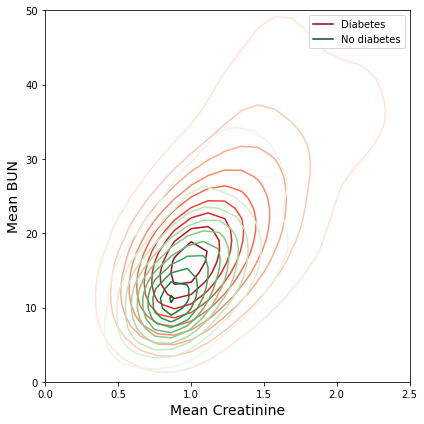

In [29]:
no_diabetes = train_df[train_df.d1_creatinine_mean.notna() & train_df.d1_bun_mean.notna() & (train_df.diabetes_mellitus == 0)].head(1000) # only use first 1000 samples for fast visualization (this is not a 100% accurate respresentation)
diabetes = train_df[train_df.d1_creatinine_mean.notna() & train_df.d1_bun_mean.notna() & (train_df.diabetes_mellitus == 1)].head(1000) # only use first 1000 samples for fast visualization (this is not a 100% accurate respresentation)

# Set up the figure
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Draw the two density plots
sns.kdeplot(diabetes.d1_creatinine_mean, diabetes.d1_bun_mean, cmap="Reds", label='Diabetes')
sns.kdeplot(no_diabetes.d1_creatinine_mean, no_diabetes.d1_bun_mean, cmap="Greens", label='No diabetes')

ax.set_xlim([0, 2.5])
ax.set_ylim([0, 50])
ax.set_xlabel('Mean Creatinine', fontsize=14)
ax.set_ylabel('Mean BUN', fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

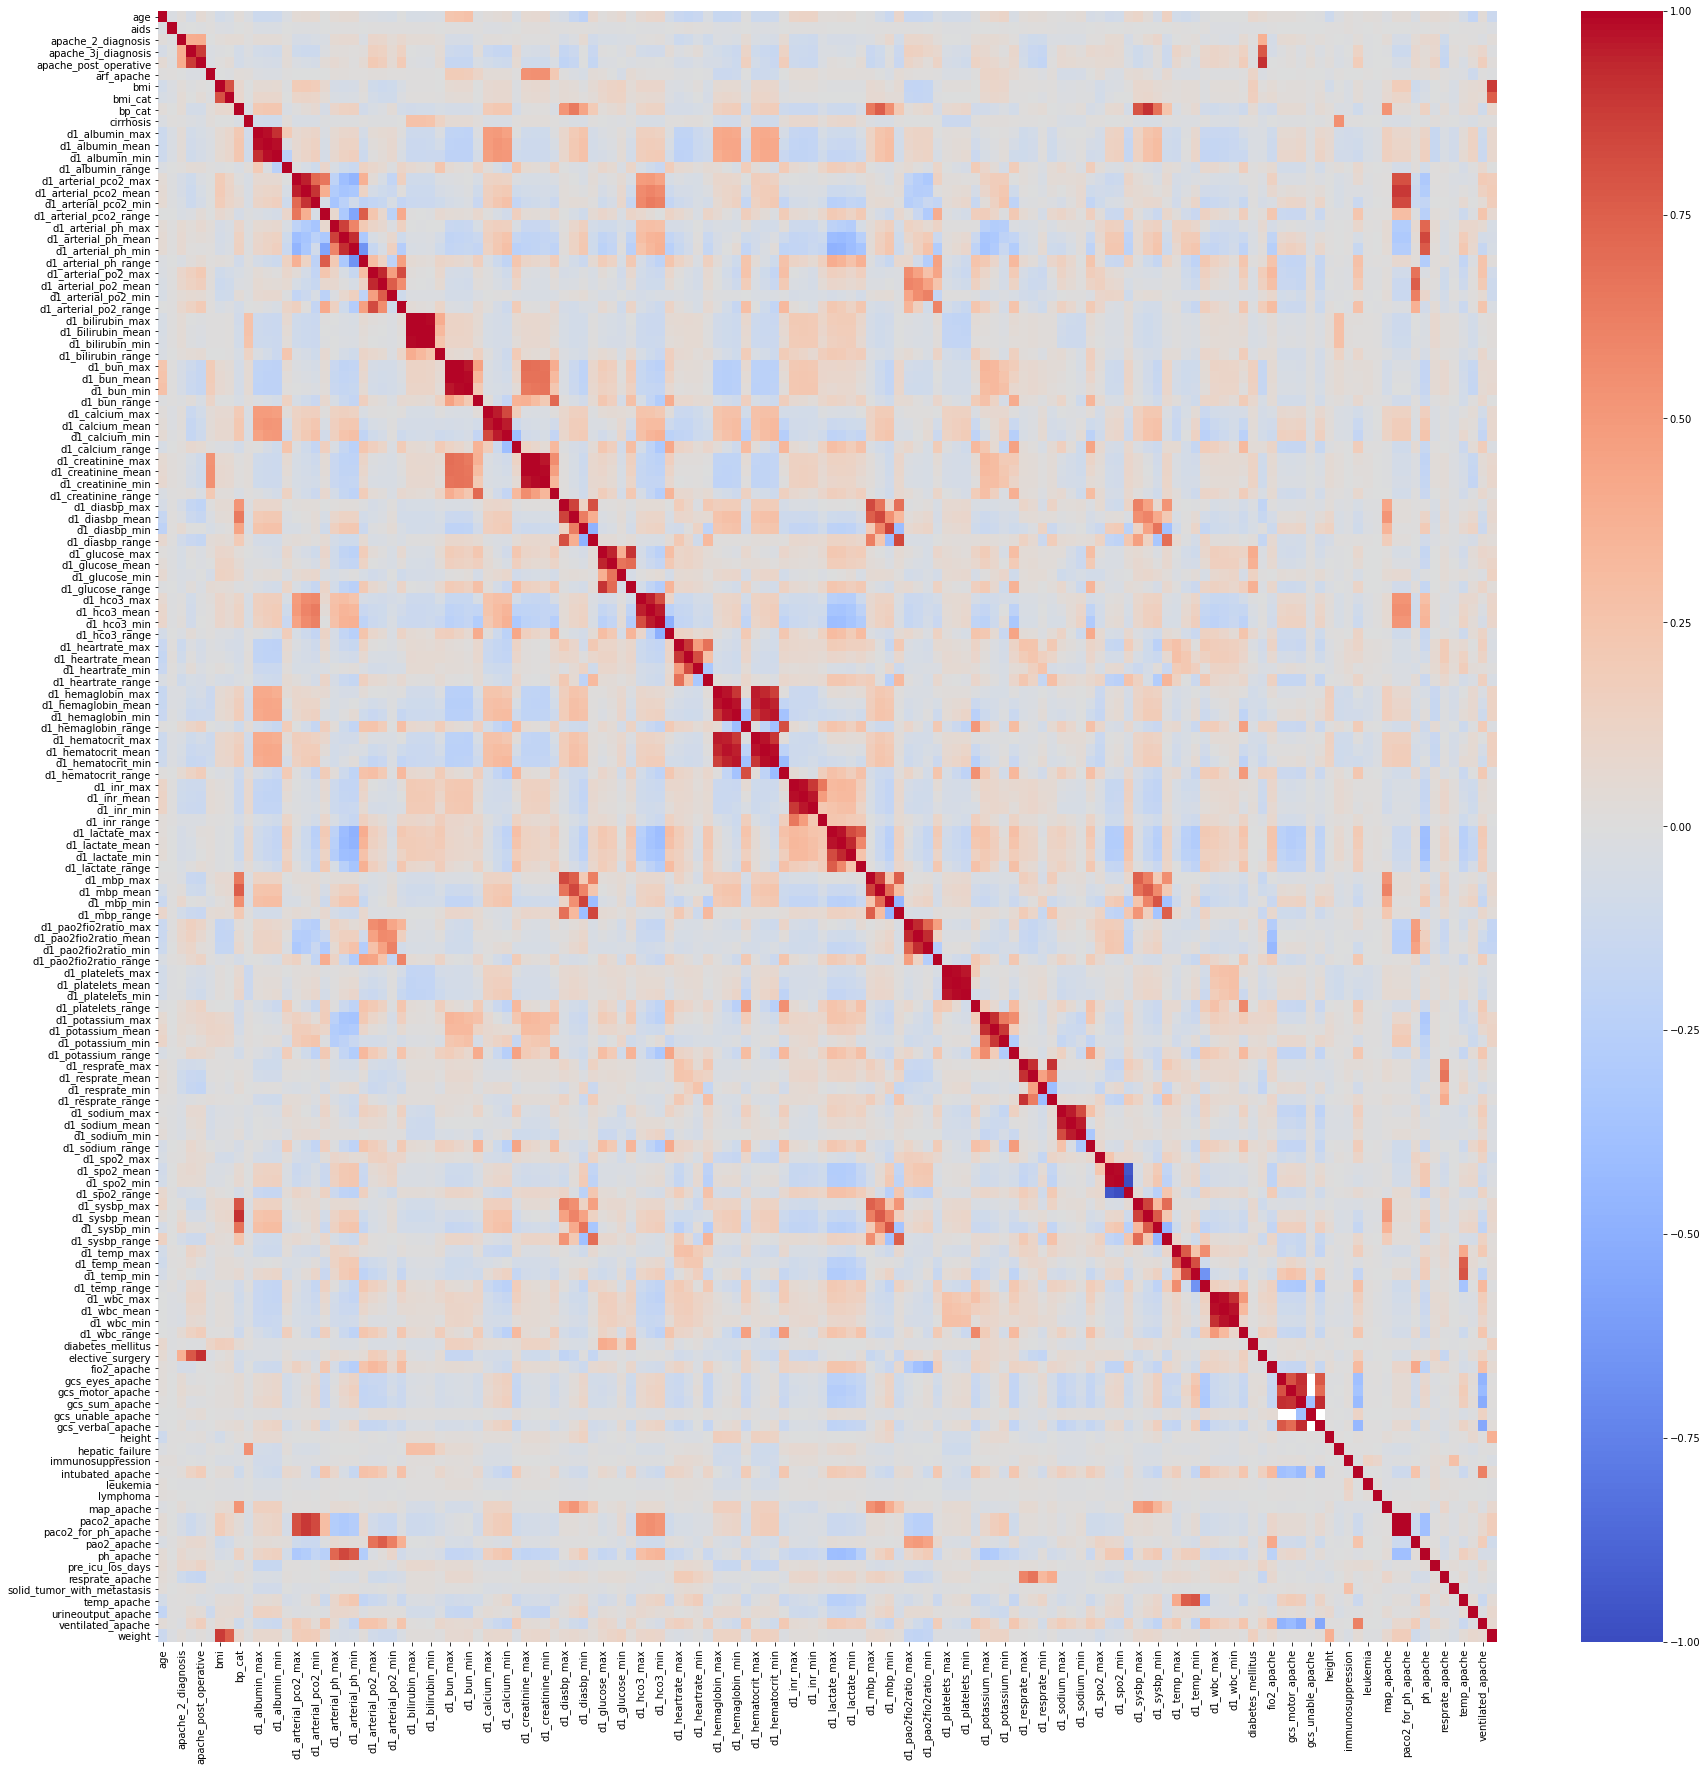

In [30]:
temp = list(train_df.columns)
temp.sort()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 30))

sns.heatmap(train_df[temp].corr(),#.sort_values(by='diabetes_mellitus', ascending=False), 
            vmin=-1, vmax=1, cmap='coolwarm');

## APACHE-Score

The Acute Physiology And Chronic Health Evaluation (APACHE) is a scoring system used in ICUs to measure the severity of diseases. It is applied within 24 hours of admission of a patient to an ICU. The score is computed based on severeal measurements and ranges from 0 to 71. The higher the score the more higher the risk of death. 

| Physiologic Variable | +4 | +3 | +2 |+1 | 0 | 1 | 2 | 3 | 4 | 5 | 6 |
|:---------:|----------|--------------------|-|-|-|-|-|-|-|-|-|
| Age (`age`) |  |  | | | < 45 |  | 45-54 | 55-64 |  | 65-74 | >74|
| Body Temperature [°C] (`temp_apache`)| ≥41 | 39-40.9 | | 38.5-38.9 | 36-38.4 | 34-35.9 | 32-33.9 | 30-31.9 | ≤29,9 | | |
| Mean Arterial Pressure [mmHg]  (`map_apache`) | ≥160 | 13-0-159 | 110-129 | | 70-109 |  | 50-69 |  | ≤49 | | |
| Heart Rate [/min]  (`heart_rate_apache`) | ≥180 | 140-179 | 110-139 | | 70-109 |  | 50-69 | 40-54 | ≤39 | | |
| Respiratory Rate [/min] (`resprate_apache`) | ≥50 | 35-49 | |25-34 | 12-24 | 10-11 | 6-9 |  | ≤5 | | |
| Oxygenatation [%] (`fio2_apache`) | ≥500 | 350-499 |200-349 | | <200 | TODO | TODO | TODO | TODO | | |
| Blood pH (`ph_apache`)   | ≥7.7 | 7.6-7.69 | |7.5-7.59 | 7.33-7.49 |  | 7.25-7.32 | 7.15-7.24 | ≤7.15 | | |
| Serum Sodium (`sodium_apache` [mmol/L])   | ≥180 | 160-179 |155-159 |150-154 | 130-149 |  | 120-129 | 111-119 | ≤110 | | |
| Serum Potassium   | ≥7 | 6-6.9 | | 5.5-5.9 | 3.5-5.4 | 3-3.4 | 2.5-3.9 |  | ≤2.5 | | |
| Creatinine [mg/dl] (`creatinine_apache` [micromol/L])   | ≥3.5 | 2-3.4 |1.5-1.9 | | 0.6-1.4 |  | ≤0.6 |  |  | | |
| Hematocrit [%]  (`hematocrit_apache`)   | ≥60 |  |50-59.9 |46-49.9 | 30-45.9 |  | 20-29.9 |  | ≤20 | | |
| White Blood Cell Count [x1000] (`wbc_apache` [10^9/L])  | ≥40 |  |20-39.9 |15-19.9 | 3-14.9 |  | 1-2.9 |  | ≤1 | | |
| Glasgow Coma Scale  |  |  | | | 15 - GCS Score |  |  |  |  | |  |

**work in progress**


# Experiements
In the following small experiement, I want to try out whether we are able to distinguish the three types of diabetes: Type 1 diabetes, Type 2 diabetes, gestational diabetes.

For this we will cluster the diabetes patients (`diabetes_mellitus`) in the training data with the simple **KMeans algorithm**.We will search for three clusters (`n_clusters=3`). The small experiemnt will be evaluated as successful if the resulting clusters show following characteristics:
* gestational disabetes: only contains females, age distribution with mean around 30 and range between 16 and 45 roughly speaking, small cluster
* type 2 diabetes: largest cluster (about 90% of all diabetes patients data)
* type 1 diabetes: small cluster

**work in progress:** Currently the experiment seems to be failing...

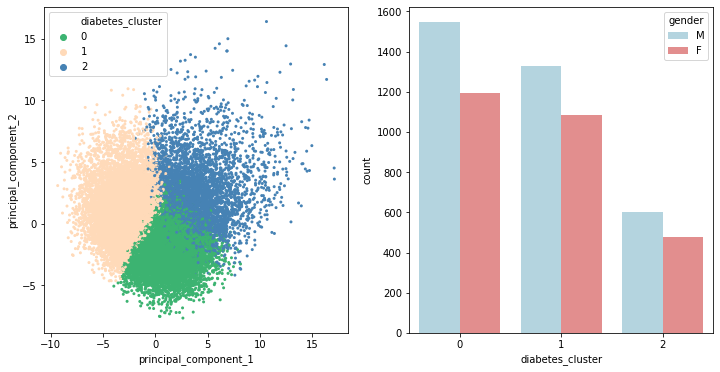

In [31]:
from sklearn.cluster import KMeans
import category_encoders as ce

exclude_cols = ['diabetes_mellitus',
                'icu_admit_source', 'icu_type', 'hospital_admit_source',  'pre_icu_los_days', 
                'ethnicity'
               ]
features = [f for f in train_df.columns if f not in exclude_cols]

diabetes_patients = train_df[train_df.diabetes_mellitus == 1][features].copy()
diabetes_patients['gender'] = diabetes_patients['gender'].fillna('Unknown')

for c in diabetes_patients.columns:
    if diabetes_patients[c].isna().sum(axis=0)/len(diabetes_patients) > 50:
        diabetes_patients.drop(c, axis=1, inplace=True)


# Categorical Feature Encoding
object_cols = [col for col in diabetes_patients.columns if ((diabetes_patients[col].dtype != np.float64) & (diabetes_patients[col].dtype != np.int64))] 

# Apply OH Encoding
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
OH_cols_train = pd.DataFrame(ohe.fit_transform(diabetes_patients[object_cols]))
OH_cols_train.index = diabetes_patients.index

# Drop original categorical columns and replace with OH encoded columns
diabetes_patients.drop(object_cols, axis=1, inplace=True)
diabetes_patients = pd.concat([diabetes_patients, OH_cols_train], axis=1)

# Apply standarscaler
scaled_data = StandardScaler().fit_transform(diabetes_patients)
diabetes_patients = pd.DataFrame(data = scaled_data, 
                           columns = diabetes_patients.columns)

for col in diabetes_patients.columns:
    diabetes_patients[col] = diabetes_patients[col].fillna(diabetes_patients[col].mean()) # 
    
pca_input = diabetes_patients.copy()
# Cluster patients with kMeans
kmeans = KMeans(n_clusters=3, random_state=42).fit(diabetes_patients)

# Assign cluster labels to data set
diabetes_patients['diabetes_cluster'] = kmeans.labels_
diabetes_patients['gender'] = train_df[train_df.diabetes_mellitus == 1]['gender'].copy()

pca = PCA(n_components=2)
principal_components = pca.fit_transform(pca_input)
principal_df = pd.DataFrame(data = principal_components, 
                           columns = ['principal_component_1', 'principal_component_2'])
principal_df['diabetes_cluster'] = kmeans.labels_

# Set up the figure
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(x=principal_df.principal_component_1, y=principal_df.principal_component_2, 
                linewidth=0, marker='.', 
                hue=principal_df.diabetes_cluster, palette=['mediumseagreen', 'peachpuff', 'steelblue'],
               ax=ax[0])

sns.countplot(diabetes_patients['diabetes_cluster'], hue=diabetes_patients['gender'], palette=['lightblue', 'lightcoral'],ax=ax[1])

plt.show()

**work in progress**


In [32]:
"""comparison_df = train_df.groupby('diabetes_mellitus').mean().T
comparison_df['delta'] =  comparison_df[0]-comparison_df[1]
comparison_df['delta_norm'] =  comparison_df['delta'] / comparison_df[0] * 100
comparison_df['delta_norm'] =  comparison_df['delta_norm'].abs()
comparison_df.sort_values(by='delta_norm', ascending=False).head(50)



import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
#features = ['d1_glucose_mean', 'd1_glucose_range', 'd1_creatinine_mean', 'bmi', 'd1_bun_mean', 'bp_cat', 'arf_apache', 
#            'urineoutput_apache', 'age', 'apache_2_diagnosis', 'apache_3j_diagnosis'] #0.698097
X = train_df[features]
y = train_df[['diabetes_mellitus']]
X_test = test_df[features]


model_params = {
    "objective": "binary",
    "learning_rate": 0.1, 
    "seed": 42,
    'max_depth': 7,
    'colsample_bytree': .85,
    "subsample": .85,
}
    
train_params = {
    "early_stopping_rounds": 100,
    "verbose_eval": 50,
}

SEED = 42
N_SPLITS = 5

# Initialize variables
y_oof_pred = np.zeros(len(X))
y_test_pred = np.zeros(len(X_test))

kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)


for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}:")

    # Prepare training and validation data
    X_train = X.iloc[train_idx].reset_index(drop=True)
    X_val = X.iloc[val_idx].reset_index(drop=True)

    y_train = y.iloc[train_idx].reset_index(drop=True)
    y_val = y.iloc[val_idx].reset_index(drop=True)  

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    # Define model
    model = lgb.train(params=model_params,
                      train_set=train_data,
                      valid_sets=[train_data, val_data],
                      **train_params)

    # Calculate evaluation metric: Root Mean Squared Error (RMSE)
    y_val_pred = np.round(model.predict(X_val)).astype(int)
    score = f1_score(y_val, y_val_pred, average='macro')
    print(f"F1 Score: {score:.5f}\n")

    y_oof_pred[val_idx] = y_val_pred
    # Make predictions
    y_test_pred += model.predict(X_test)

# Calculate evaluation metric for out of fold validation set
#oof_score = np.sqrt(mean_squared_error(y, y_oof_pred))
oof_score = f1_score(y, np.round(y_oof_pred).astype(int), average='macro')
print(f"OOF F1 Score: {oof_score: 5f}")


from sklearn.metrics import confusion_matrix
confusion_matrix(y, np.round(y_oof_pred).astype(int))
from sklearn.metrics import roc_auc_score
roc_auc_score(y, y_oof_pred)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type="gain"),X.columns)), columns=['Value','Feature'])

feature_imp.sort_values('Value', ascending=False).head(50)
"""

'comparison_df = train_df.groupby(\'diabetes_mellitus\').mean().T\ncomparison_df[\'delta\'] =  comparison_df[0]-comparison_df[1]\ncomparison_df[\'delta_norm\'] =  comparison_df[\'delta\'] / comparison_df[0] * 100\ncomparison_df[\'delta_norm\'] =  comparison_df[\'delta_norm\'].abs()\ncomparison_df.sort_values(by=\'delta_norm\', ascending=False).head(50)\n\n\n\nimport lightgbm as lgb\nfrom sklearn.model_selection import StratifiedKFold\nfrom sklearn.metrics import f1_score\n\nimport lightgbm as lgb\nfrom sklearn.model_selection import StratifiedKFold\nfrom sklearn.metrics import f1_score\n#features = [\'d1_glucose_mean\', \'d1_glucose_range\', \'d1_creatinine_mean\', \'bmi\', \'d1_bun_mean\', \'bp_cat\', \'arf_apache\', \n#            \'urineoutput_apache\', \'age\', \'apache_2_diagnosis\', \'apache_3j_diagnosis\'] #0.698097\nX = train_df[features]\ny = train_df[[\'diabetes_mellitus\']]\nX_test = test_df[features]\n\n\nmodel_params = {\n    "objective": "binary",\n    "learning_rate": 0.

# Dealing with Imbalanced Data
Data imbalance in the target variable can be an issue. First of all, it is important to think about the evaluation metric. 

In this case using accuracy as the evaluation metric is insufficient. To demonstrate, let's assume, we have 10 data points with 8 non-diabetes patients and 2 diabetes patients. If we blindly predicted all 10 patients as non diabetic, we would have an accuracy of 80%. Sounds pretty good -  but we did not classify the patients with diabetes correctly and we cannot provide them the best care. That's not very good and shows that **accuracy is not a sufficent metric when dealing with imbalanced data**.

In this competition the evaluation metric is **Area under the Receiver Operating Characteristic (ROC) curve**. Another suitable metric that is often used to evaluate imbalanced classification problems is the **F1 Macro score**.

In [33]:
y_true = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
y_pred = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")
print(f"Area under the Receiver Operating Characteristic curve: {roc_auc_score(y_true, y_pred)}")
print(f"F1 Macro Score: {f1_score(y_true, y_pred, average='macro')}")

Accuracy Score: 0.8
Area under the Receiver Operating Characteristic curve: 0.5
F1 Macro Score: 0.4444444444444445


Additionally, when working with imbalanced data you can try **Resampling**. This method creates copies of the minority class and removed data points from the majority class to create equal amounts of samples for each class.

Here are some further ressources:
* [Resampling strategies for imbalanced datasets](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)
* [Methods for Dealing with Imbalanced Data](https://www.kaggle.com/tboyle10/methods-for-dealing-with-imbalanced-data)

# References
[1] American Diabetes Association. (2019). 2. Classification and diagnosis of diabetes: standards of medical care in diabetes—2019. Diabetes care, 42(Supplement 1), S13-S28.

[2] World Health Organization (2020): Diabetes. https://www.who.int/news-room/fact-sheets/detail/diabetes 

[3] Nnamoko, N., & Korkontzelos, I. (2020). Efficient treatment of outliers and class imbalance for diabetes prediction. Artificial Intelligence in Medicine, 104, 101815.

[4] Sirivole, M. R., & Eturi, S. A. (2017). A study on blood urea and serum creatinine in diabetes mellitus from Sangareddy District, Telangana, India. Intern J Med Health Res, 3, 132-6.
